In [1]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os
# %matplotlib inline

In [2]:
class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

In [3]:
class gameEnv():
    def __init__(self,size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        a = self.reset()
        plt.imshow(a,interpolation = "nearest")
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        for i in range(4):
            goal=gameOb(self.newPosition(),1,1,1,1,'goal')
            self.objects.append(goal)
            if i < 2:
                hole = gameOb(self.newPosition(),1,1,0,-1,'fire')
                self.objects.append(hole)
        state = self.renderEnv()
        self.state = state
        return state
    
    def moveChar(self,direction):
        hero = self.objects[0]
        if direction == 0 and hero.y >=1:
            hero.y -=1
        if direction == 1 and hero.y <=self.sizeY-2:
            hero.y +=1
        if direction == 2 and hero.x >=1:
            hero.x -=1
        if direction == 3 and hero.y <=self.sizeX-2:
            hero.x +=1    
        self.objects[0] = hero
        
    def newPosition(self):
        points = []
        for t in itertools.product(range(self.sizeX),range(self.sizeY)):
            points.append(t)
        for objectA in self.objects:
            points.remove((objectA.x,objectA.y))
        location = np.random.choice(range(len(points)),replace = False)
        return points[location]
    
    def checkGoal(self):
        hero=self.objects[0]
        others=self.objects[1:]
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                return other.reward,False
        return 0.0,False
    
    def renderEnv(self):
        a = np.ones([self.sizeY+2,self.sizeX+2,3])
        a[1:-1,1:-1,:] = 0
        for item in self.objects:
            a[item.y+1:item.y+item.size+1,item.x+1:item.x+item.size+1
              ,item.channel] = item.intensity
        b = scipy.misc.imresize(a[:,:,0],[84,84,1],interp='nearest')
        c = scipy.misc.imresize(a[:,:,1],[84,84,1],interp='nearest')
        d = scipy.misc.imresize(a[:,:,2],[84,84,1],interp='nearest') 
        a = np.stack([b,c,d],axis=2)
        return a
    
    def step(self,action):
        self.moveChar(action)
        reward,done = self.checkGoal()
        state = self.renderEnv()
        return state,reward,done

In [4]:
env=gameEnv(size=5)

In [5]:
class Qnetwork():
    def __init__(self,h_size):
        self.scalarInput = tf.placeholder(shape=[None,84*84*3],
                                         dtype=tf.float32)
        self.imageIn=tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = tf.contrib.layers.convolution2d(
            inputs=self.imageIn,num_outputs=32,
            kernel_size=[8,8],stride=[4,4],
            padding='VALID',biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(
            inputs=self.conv1,num_outputs=64,
            kernel_size=[4,4],stride=[2,2],
            padding='VALID',biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(
            inputs=self.conv2,num_outputs=64,
            kernel_size=[3,3],stride=[1,1],
            padding='VALID',biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(
            inputs=self.conv3,num_outputs=512,
            kernel_size=[7,7],stride=[1,1],
            padding='VALID',biases_initializer=None)
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA=tf.contrib.layers.flatten(self.streamAC)
        self.streamV=tf.contrib.layers.flatten(self.streamVC)
        self.AW=tf.Variable(tf.random_normal([h_size//2,env.actions]))
        self.VW=tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage=tf.matmul(self.streamA,self.AW)
        self.value=tf.matmul(self.streamV,self.VW)
        
        self.Qout=self.value+tf.subtract(self.Advantage,tf.reduce_mean(
            self.Advantage,reduction_indices=1,keep_dims=True))
        self.predict=tf.argmax(self.Qout,1)
        
        self.targetQ=tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions=tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot=tf.one_hot(self.actions,env.actions,
                                       dtype=tf.float32)
        self.Q=tf.reduce_sum(tf.multiply(self.Qout,self.actions_onehot),
                            reduction_indices=1)
        self.td_error=tf.square(self.targetQ-self.Q)
        self.loss=tf.reduce_mean(self.td_error)
        self.updateModel=tf.train.AdamOptimizer(0.0001).minimize(self.loss)

In [6]:
class experience_buffer():
    def __init__(self,buffer_size=50000):
        self.buffer=[]
        self.buffer_size=buffer_size
    
    def add(self,experience):
        if len(self.buffer)+len(experience)>self.buffer_size:
            popLength=len(self.buffer)+len(experience)-self.buffer_size
            self.buffer[0:popLength]=[]
        self.buffer.extend(experience)
        
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),
                         [size,5])

In [7]:
def flattenState(states):
    return np.reshape(states,[84*84*3])

def updateTargetGraph(tfVars,tau):
    total_vars=len(tfVars)
    qn_vars=total_vars//2
    op_holder=[]
    for idx,var in enumerate(tfVars[0:qn_vars]):
#         print(var.value())
        op_holder.append(tfVars[idx+qn_vars].assign((var.value()*tau)+\
                                    ((1-tau)*tfVars[idx+qn_vars].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)       


In [8]:
batch_size=32
update_freq=4
y=0.99
startE=1
endE=0.1
anneling_steps=10000
num_episodes=10000
pre_train_steps=10000
max_epLength=50
load_model=False
path="./dqn"
h_size=512
tau=0.001

In [9]:
mainQN=Qnetwork(h_size)
targetQN=Qnetwork(h_size)
init =tf.global_variables_initializer()

trainables = tf.trainable_variables()
targetOps=updateTargetGraph(trainables,tau)

buff=experience_buffer()

e=startE
stepDrop=(startE-endE)/anneling_steps

rList=[]
total_steps=0

saver= tf.train.Saver()
if not os.path.exists(path):
    os.makedirs(path)
    

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn\model-10000.cptk
initialize......


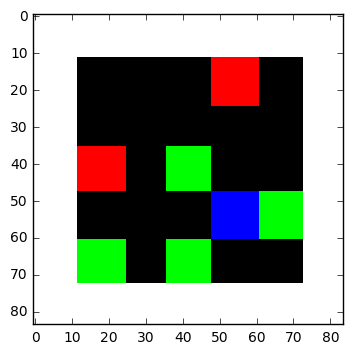

step:  1  ,reward:  0.0


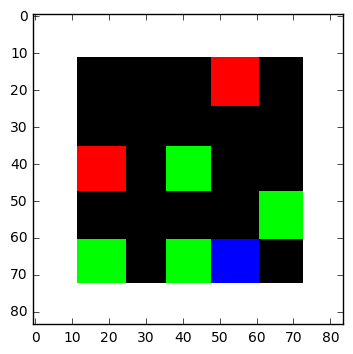

step:  2  ,reward:  0.0


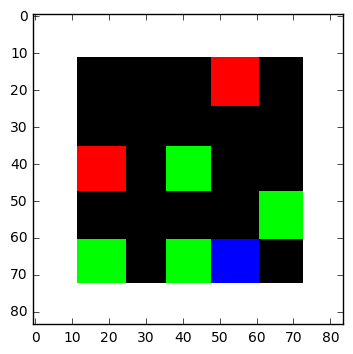

step:  3  ,reward:  0.0


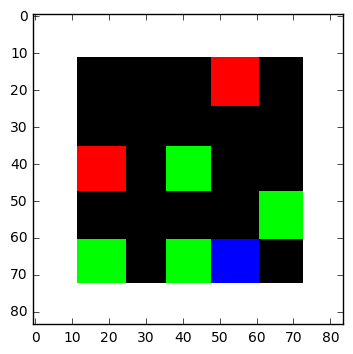

step:  4  ,reward:  0.0


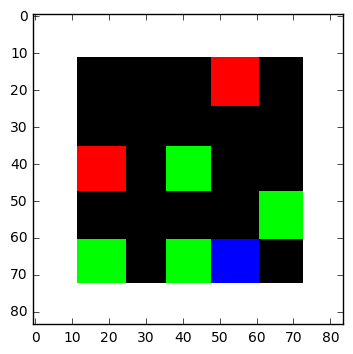

step:  5  ,reward:  0.0


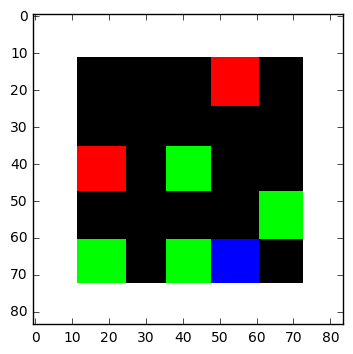

step:  6  ,reward:  0.0


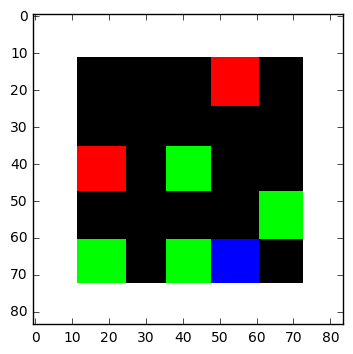

step:  7  ,reward:  0.0


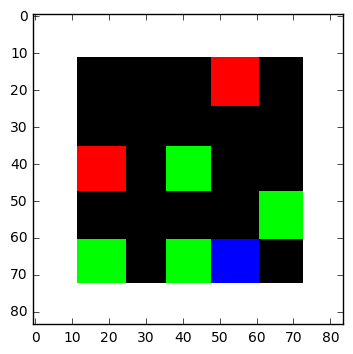

step:  8  ,reward:  0.0


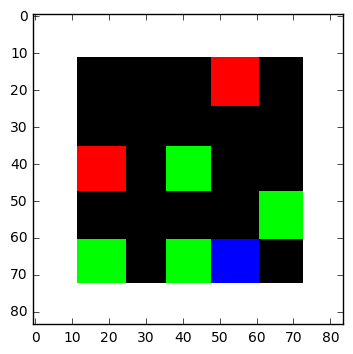

step:  9  ,reward:  0.0


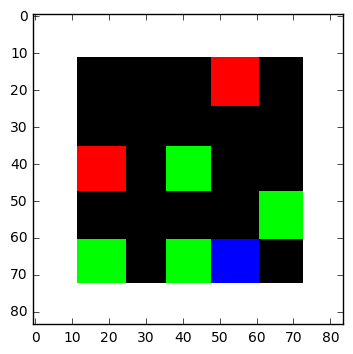

step:  10  ,reward:  0.0


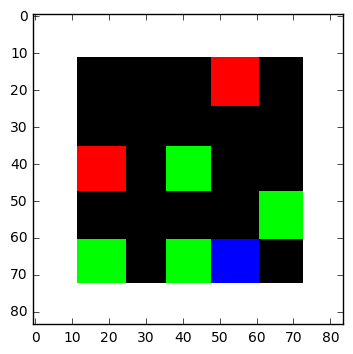

step:  11  ,reward:  0.0


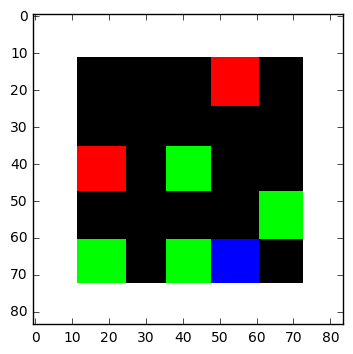

step:  12  ,reward:  0.0


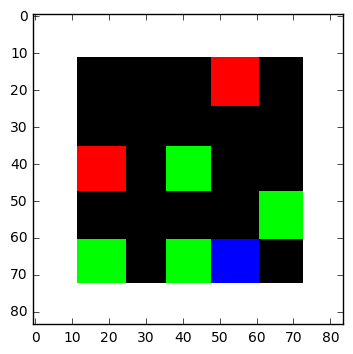

step:  13  ,reward:  0.0


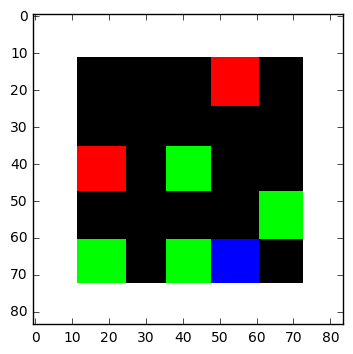

step:  14  ,reward:  0.0


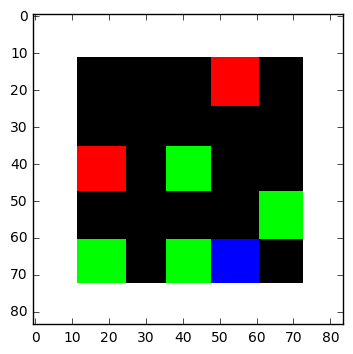

step:  15  ,reward:  0.0


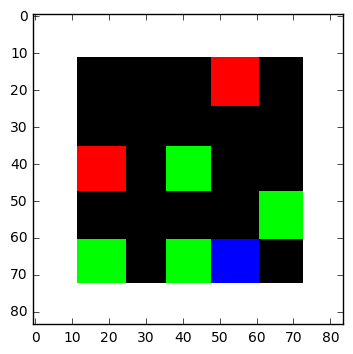

step:  16  ,reward:  0.0


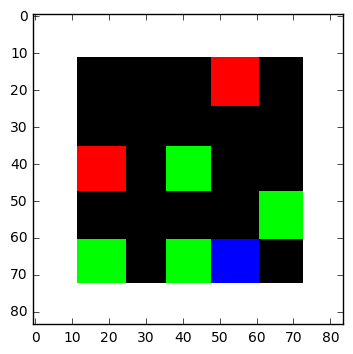

step:  17  ,reward:  0.0


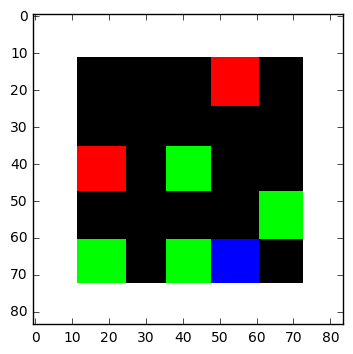

step:  18  ,reward:  0.0


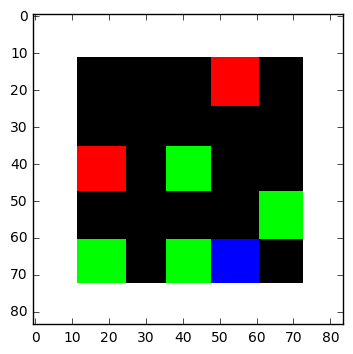

step:  19  ,reward:  0.0


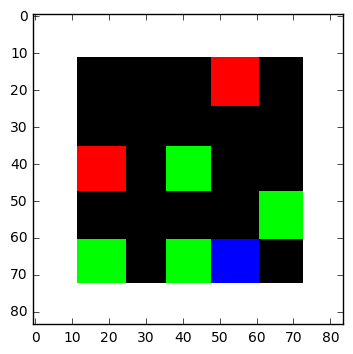

step:  20  ,reward:  0.0


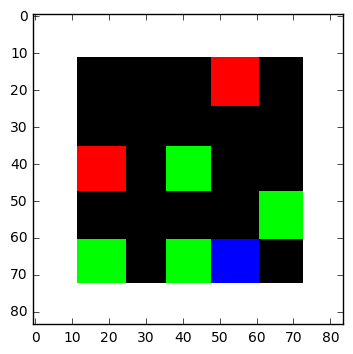

step:  21  ,reward:  0.0


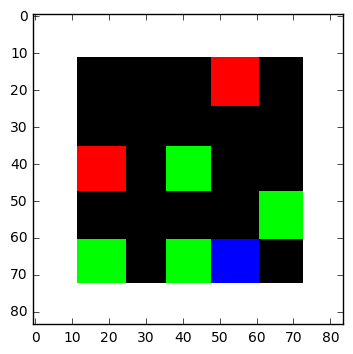

step:  22  ,reward:  0.0


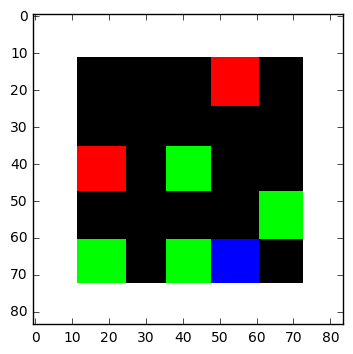

step:  23  ,reward:  0.0


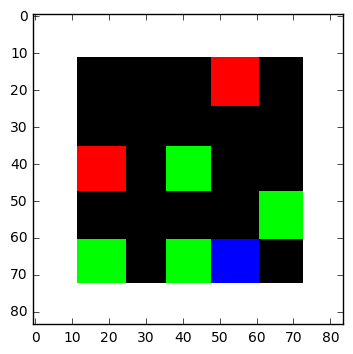

step:  24  ,reward:  0.0


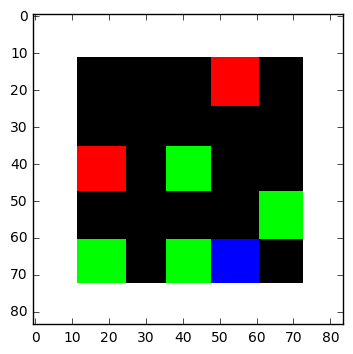

step:  25  ,reward:  0.0


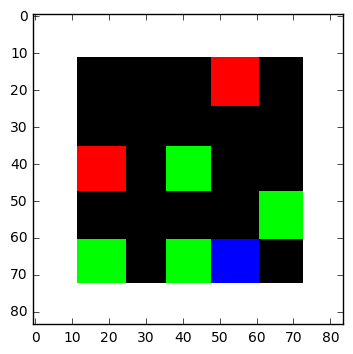

step:  26  ,reward:  0.0


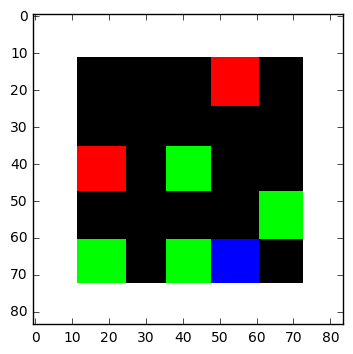

step:  27  ,reward:  0.0


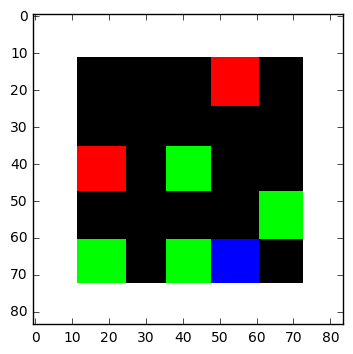

step:  28  ,reward:  0.0


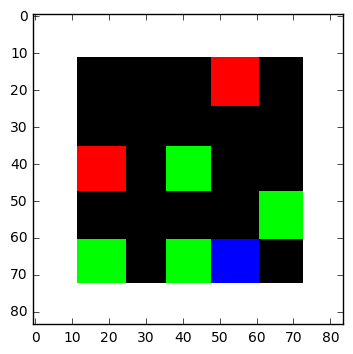

step:  29  ,reward:  0.0


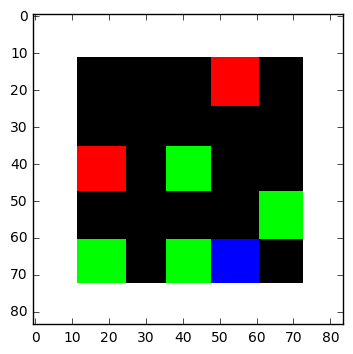

step:  30  ,reward:  0.0


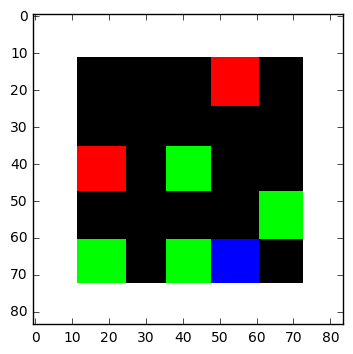

step:  31  ,reward:  0.0


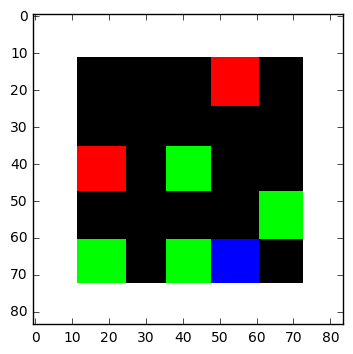

step:  32  ,reward:  0.0


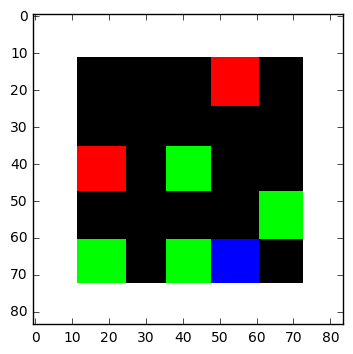

step:  33  ,reward:  0.0


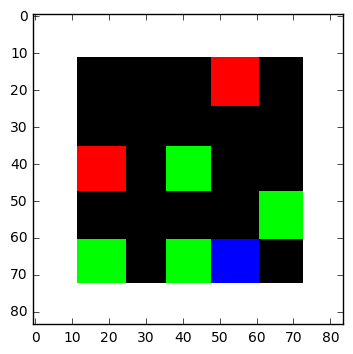

step:  34  ,reward:  0.0


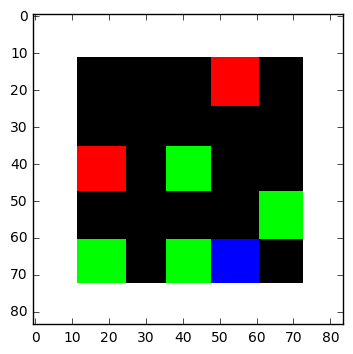

step:  35  ,reward:  0.0


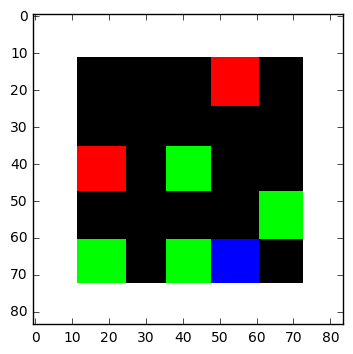

step:  36  ,reward:  0.0


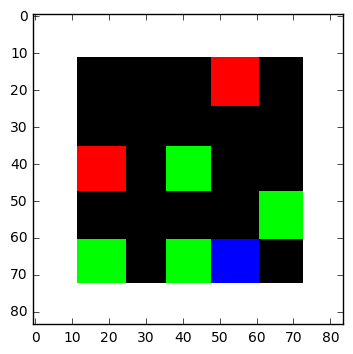

step:  37  ,reward:  0.0


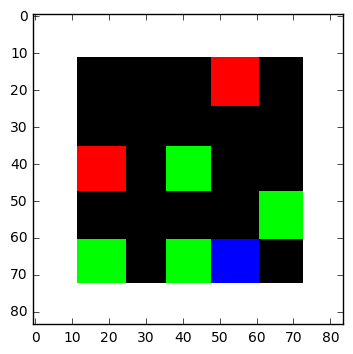

step:  38  ,reward:  0.0


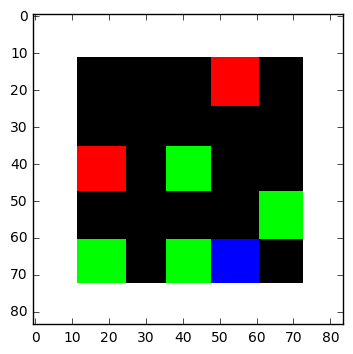

step:  39  ,reward:  0.0


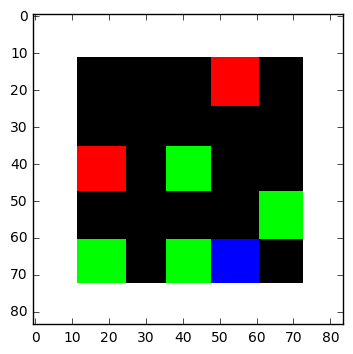

step:  40  ,reward:  0.0


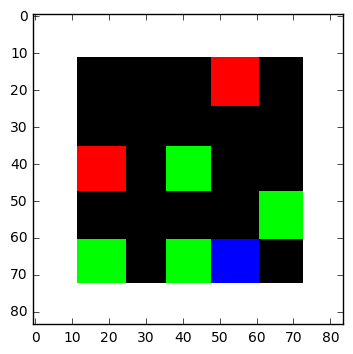

step:  41  ,reward:  0.0


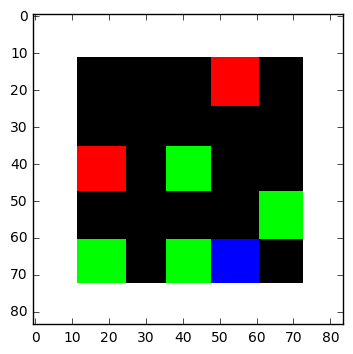

step:  42  ,reward:  0.0


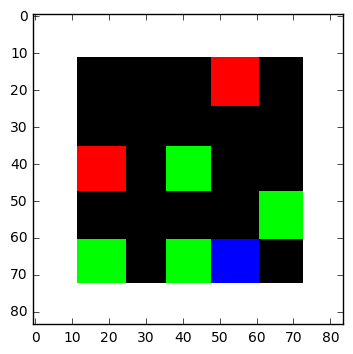

step:  43  ,reward:  0.0


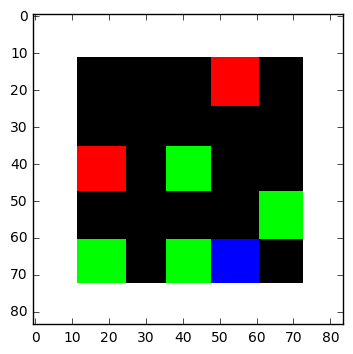

step:  44  ,reward:  0.0


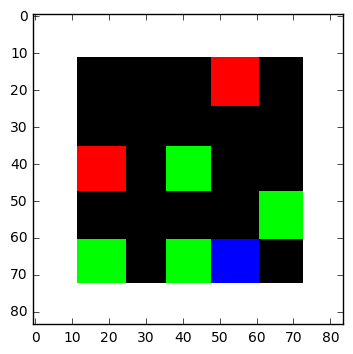

step:  45  ,reward:  0.0


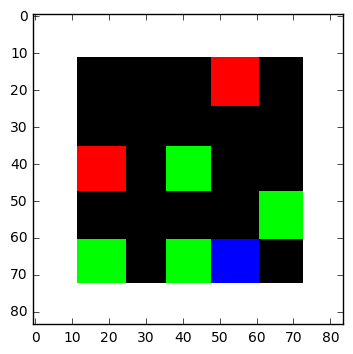

step:  46  ,reward:  0.0


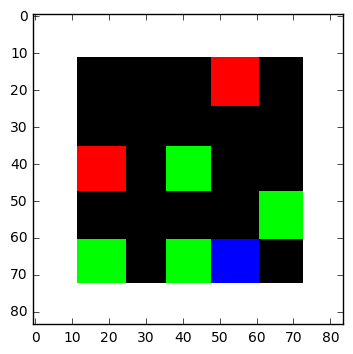

step:  47  ,reward:  0.0


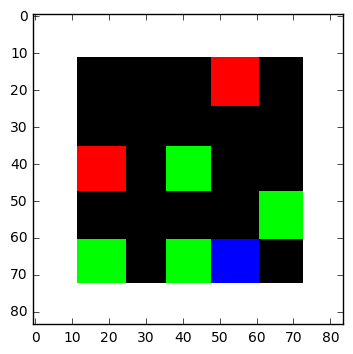

step:  48  ,reward:  0.0


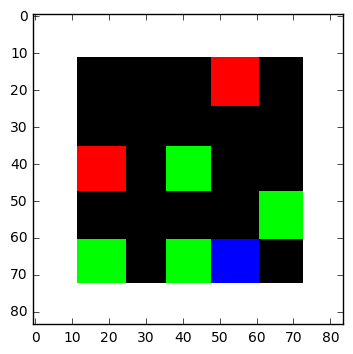

step:  49  ,reward:  0.0


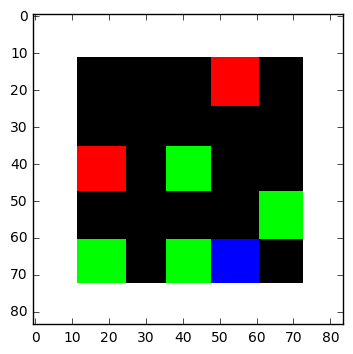

step:  50  ,reward:  0.0


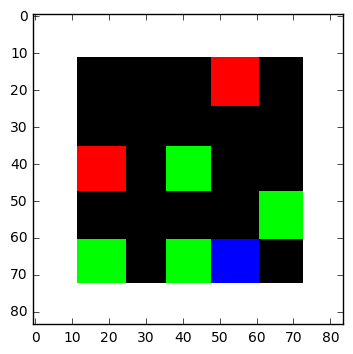

step:  51  ,reward:  0.0


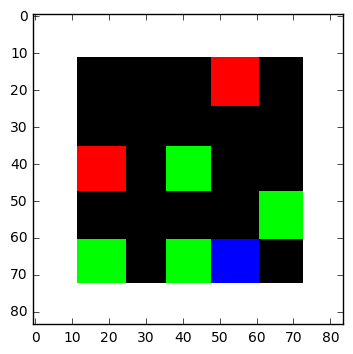

step:  52  ,reward:  0.0


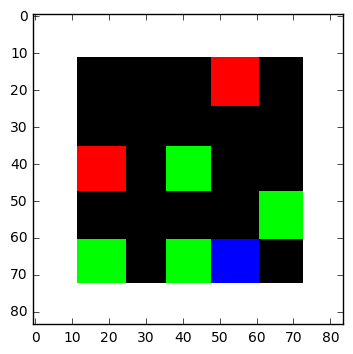

step:  53  ,reward:  0.0


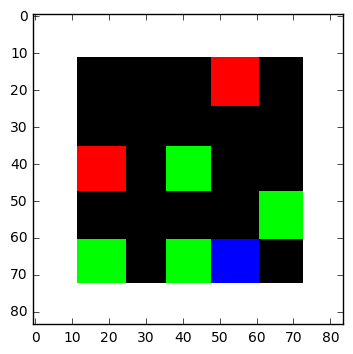

step:  54  ,reward:  0.0


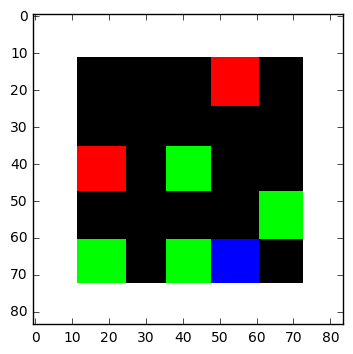

step:  55  ,reward:  0.0


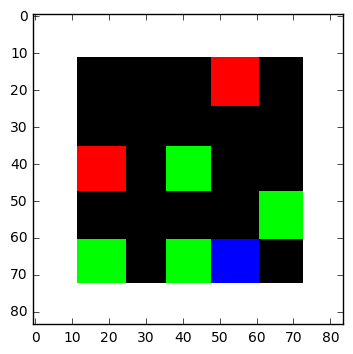

step:  56  ,reward:  0.0


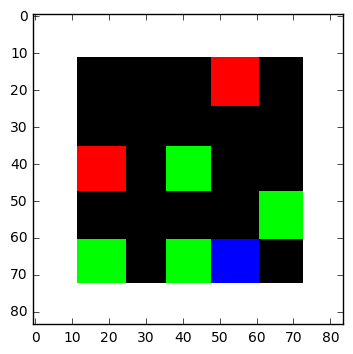

step:  57  ,reward:  0.0


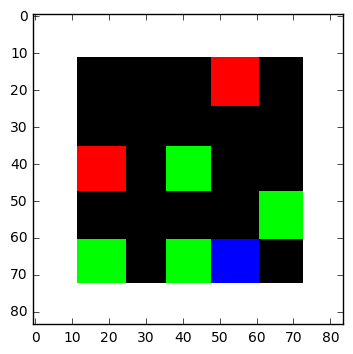

step:  58  ,reward:  0.0


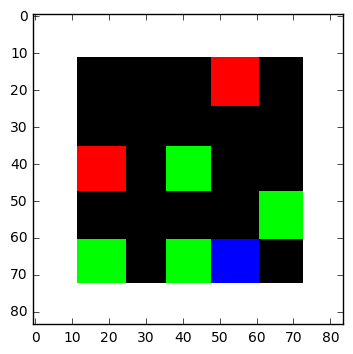

step:  59  ,reward:  0.0


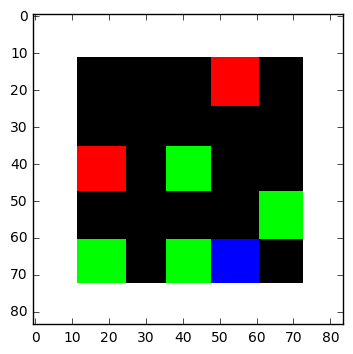

step:  60  ,reward:  0.0


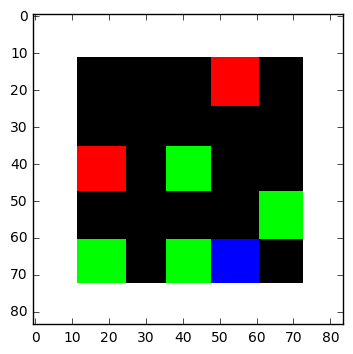

step:  61  ,reward:  0.0


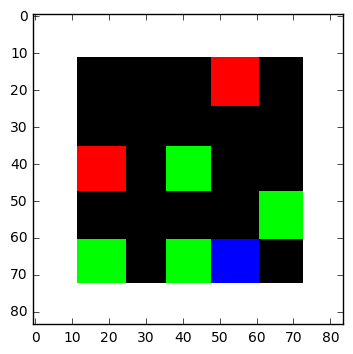

step:  62  ,reward:  0.0


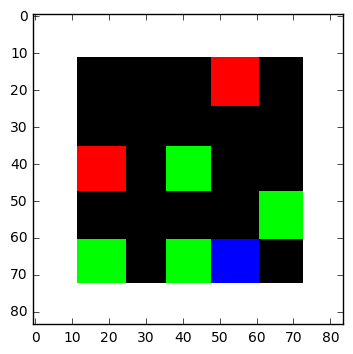

step:  63  ,reward:  0.0


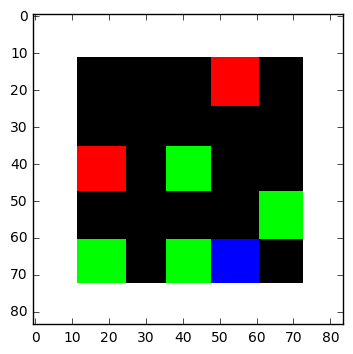

step:  64  ,reward:  0.0


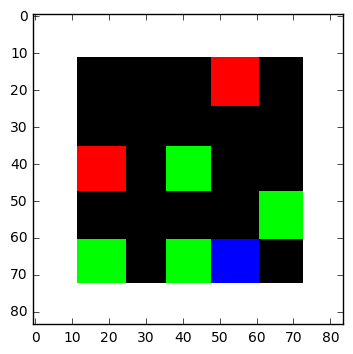

step:  65  ,reward:  0.0


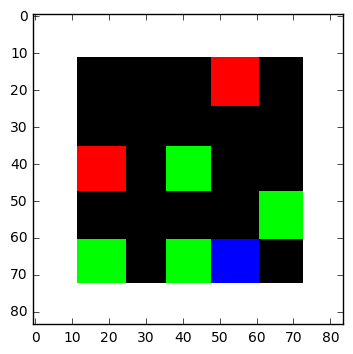

step:  66  ,reward:  0.0


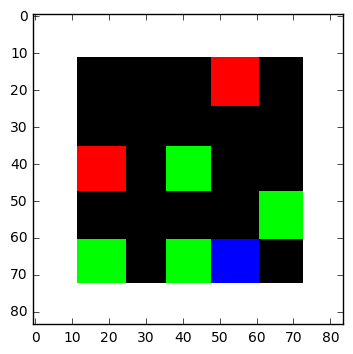

step:  67  ,reward:  0.0


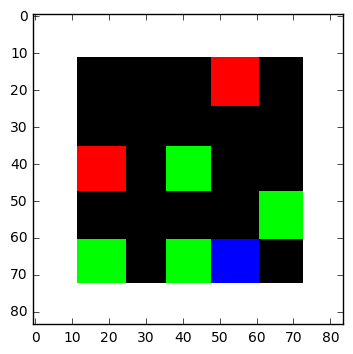

step:  68  ,reward:  0.0


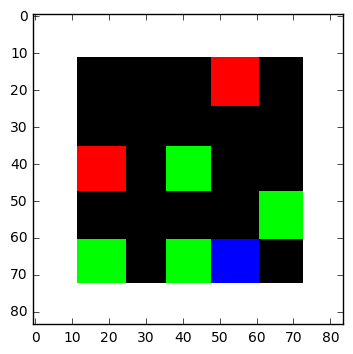

step:  69  ,reward:  0.0


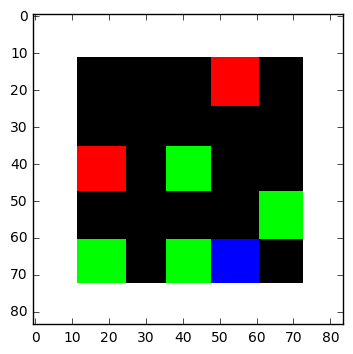

step:  70  ,reward:  0.0


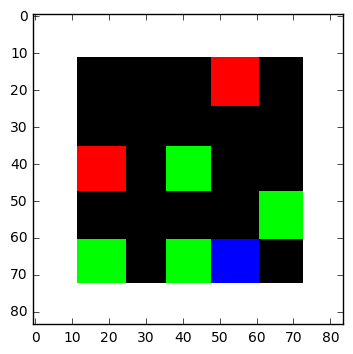

step:  71  ,reward:  0.0


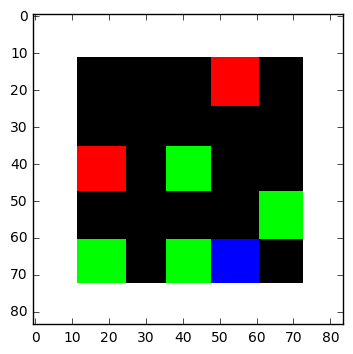

step:  72  ,reward:  0.0


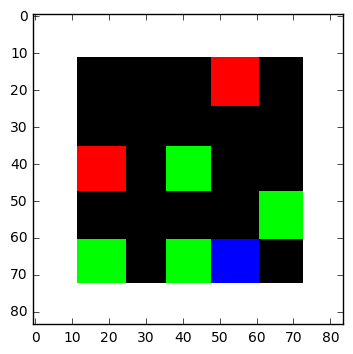

step:  73  ,reward:  0.0


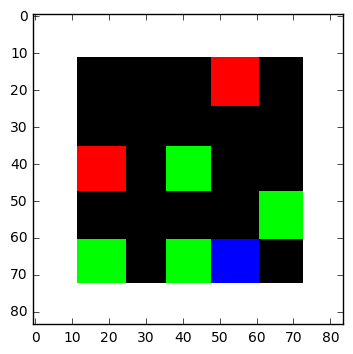

step:  74  ,reward:  0.0


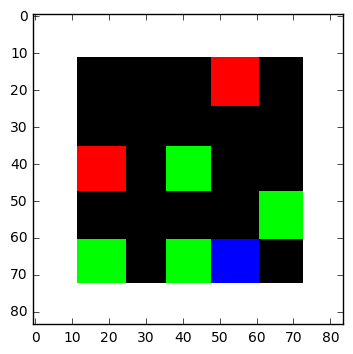

step:  75  ,reward:  0.0


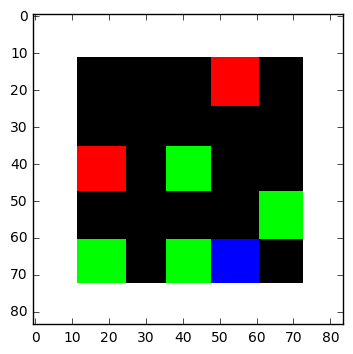

step:  76  ,reward:  0.0


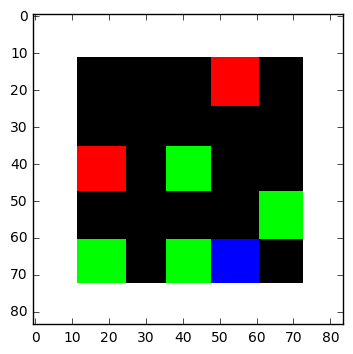

step:  77  ,reward:  0.0


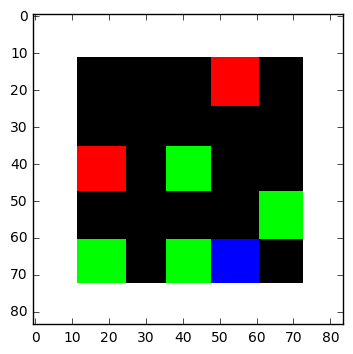

step:  78  ,reward:  0.0


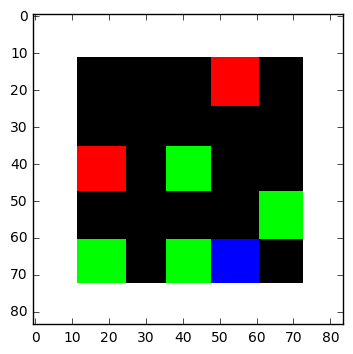

step:  79  ,reward:  0.0


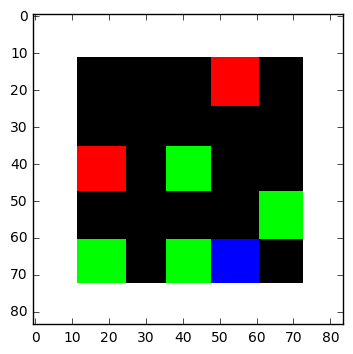

step:  80  ,reward:  0.0


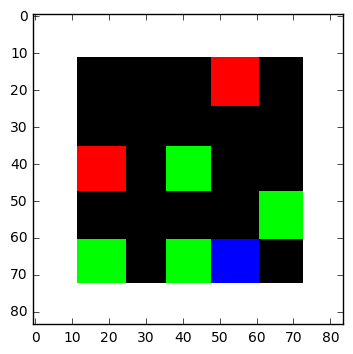

step:  81  ,reward:  0.0


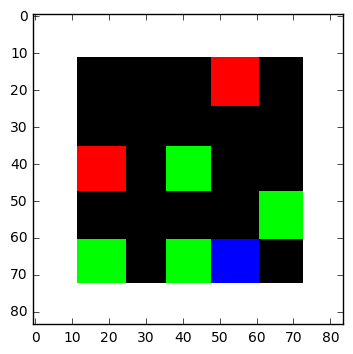

step:  82  ,reward:  0.0


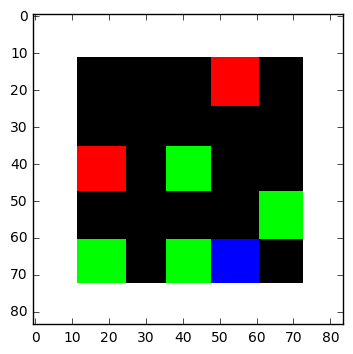

step:  83  ,reward:  0.0


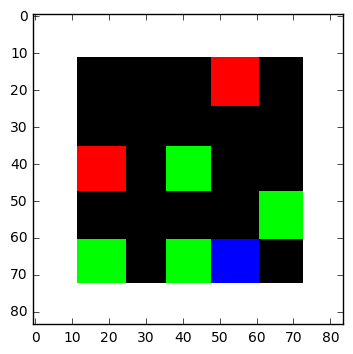

step:  84  ,reward:  0.0


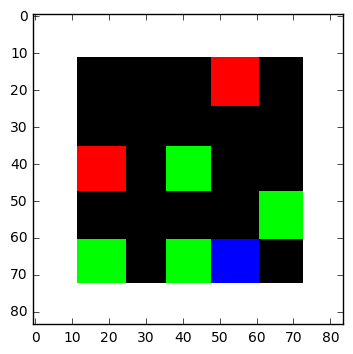

step:  85  ,reward:  0.0


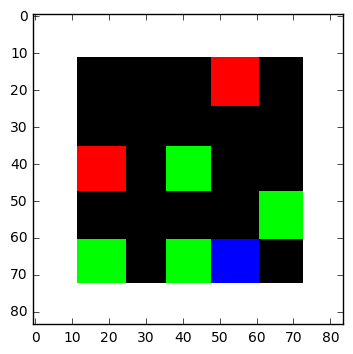

step:  86  ,reward:  0.0


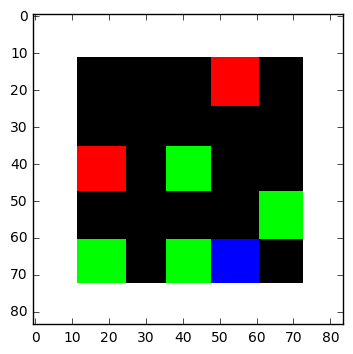

step:  87  ,reward:  0.0


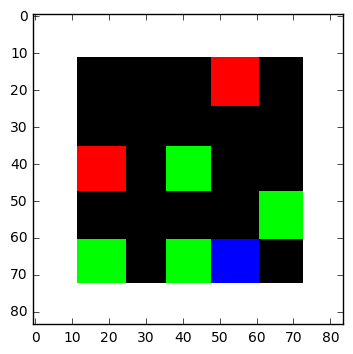

step:  88  ,reward:  0.0


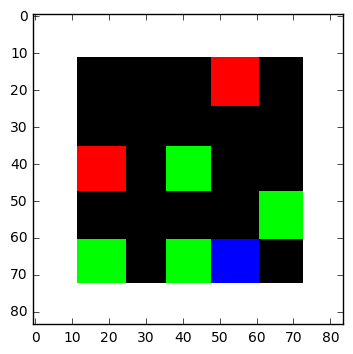

step:  89  ,reward:  0.0


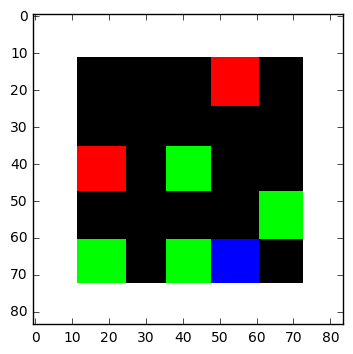

step:  90  ,reward:  0.0


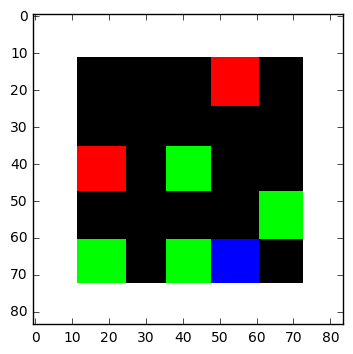

step:  91  ,reward:  0.0


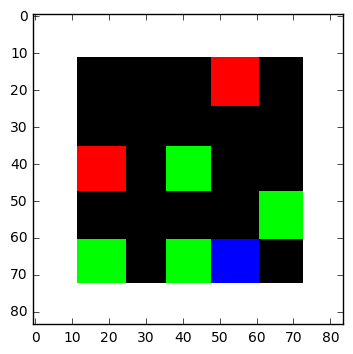

step:  92  ,reward:  0.0


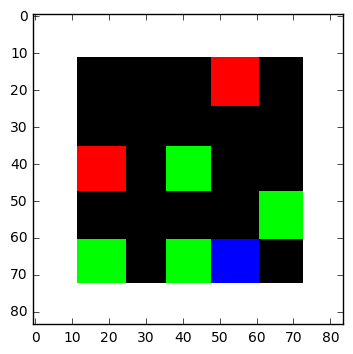

step:  93  ,reward:  0.0


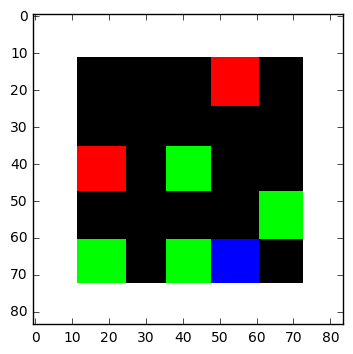

step:  94  ,reward:  0.0


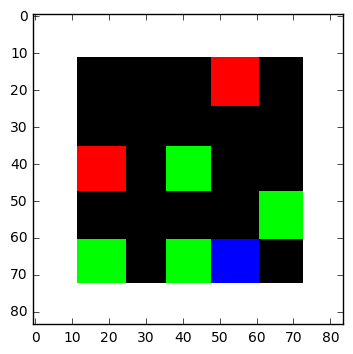

step:  95  ,reward:  0.0


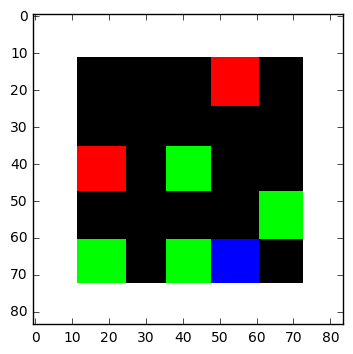

step:  96  ,reward:  0.0


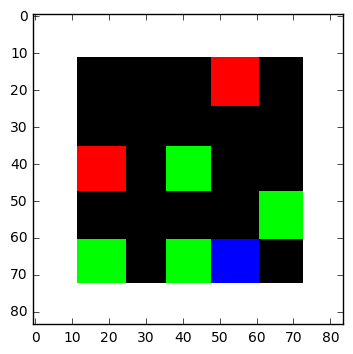

step:  97  ,reward:  0.0


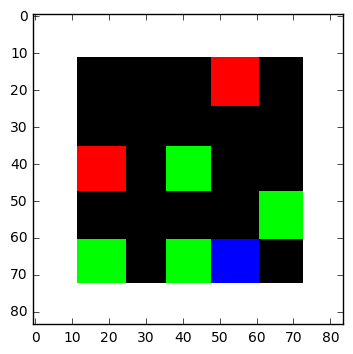

step:  98  ,reward:  0.0


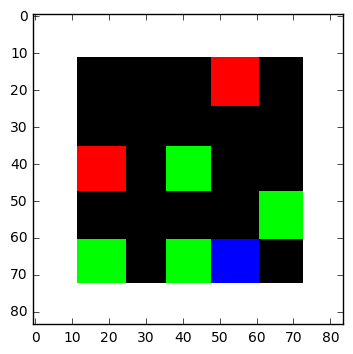

step:  99  ,reward:  0.0


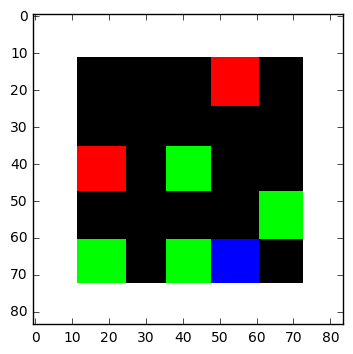

step:  100  ,reward:  0.0


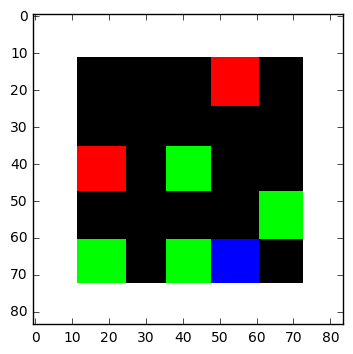

reward of this time: 0.0


In [11]:
#展示训练结果
load_model = True
with tf.Session() as sess:
    if load_model == True:
        print("Loading Model...")
        ckpt=tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(init)
        updateTarget(targetOps,sess)
    
    s = env.reset()
    print('initialize......')
    plt.imshow(s,interpolation = "nearest")
    plt.show()
    s = flattenState(s)
    d = False
    rAll = 0
    j = 0
    while j < 100:
        j+=1
        a = sess.run(targetQN.predict,
                            feed_dict={targetQN.scalarInput:[s]})[0]
        s1,r,d=env.step(a)
        print('step: ',j," ,reward: ",r)
        plt.imshow(s1,interpolation = "nearest")
        plt.show()
        s=flattenState(s1)               
        rAll+=r
#         str = input("Enter A Char(N for break): ");
#         if str=="N":
#             break       
        
    print('reward of this time:',rAll)


In [11]:
with tf.Session() as sess:
    if load_model == True:
        print("Loading Model...")
        ckpt=tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(init)
        updateTarget(targetOps,sess)
    
    for i in range(num_episodes+1):
        episodeBuffer = experience_buffer()
        s = env.reset()
        s = flattenState(s)
        d = False
        rAll = 0
        j = 0
        while j < max_epLength:
            j+=1
            if np.random.rand(1) < e or total_steps <pre_train_steps:
                a =np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,
                            feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d=env.step(a)
            s1=flattenState(s1)
            total_steps +=1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            if total_steps > pre_train_steps:
                if e > endE:
                    e-=stepDrop
                if total_steps % update_freq == 0:
                    trainBatch =buff.sample(batch_size)
                    A = sess.run(mainQN.predict,feed_dict={
                            mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q = sess.run(targetQN.Qout,feed_dict={
                            targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    doubleQ = Q[range(batch_size),A]
                    targetQ = trainBatch[:,2] + y*doubleQ
                    _ = sess.run(mainQN.updateModel,feed_dict={
                            mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                            mainQN.targetQ:targetQ,
                            mainQN.actions:trainBatch[:,1]
                        })
                    updateTarget(targetOps,sess) 
            rAll += r
            s = s1
            
            if d:
                break
        buff.add(episodeBuffer.buffer)
        rList.append(rAll)
        if i>0 and i%25 == 0:
            print('episode',i,',average reward of last 25 episode',
                 np.mean(rList[-25:]))
        if i>0 and i % 1000==0:
            saver.save (sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
    saver.save (sess,path+'/model-'+str(i)+'.cptk')

episode 25 ,average reward of last 25 episode 1.56
episode 50 ,average reward of last 25 episode 0.8
episode 75 ,average reward of last 25 episode 0.96
episode 100 ,average reward of last 25 episode 1.96
episode 125 ,average reward of last 25 episode 2.44
episode 150 ,average reward of last 25 episode 1.96
episode 175 ,average reward of last 25 episode 1.68
episode 200 ,average reward of last 25 episode 0.84
episode 225 ,average reward of last 25 episode 1.68
episode 250 ,average reward of last 25 episode 1.12
episode 275 ,average reward of last 25 episode 1.76
episode 300 ,average reward of last 25 episode 1.76
episode 325 ,average reward of last 25 episode 0.6
episode 350 ,average reward of last 25 episode 0.52
episode 375 ,average reward of last 25 episode 0.84
episode 400 ,average reward of last 25 episode 1.08
episode 425 ,average reward of last 25 episode 0.96
episode 450 ,average reward of last 25 episode 0.36
episode 475 ,average reward of last 25 episode 0.6
episode 500 ,avera